In [1]:
%matplotlib notebook

import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from imgaug import augmenters as iaa
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping
from pycocotools.coco import COCO
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

from abyss_deep_learning.keras.classification import FromAnnDataset, ClassificationDataset, caption_map_gen, onehot_gen
from abyss_deep_learning.keras.utils import batching_gen, lambda_gen
import abyss_deep_learning.abyss_dataset as dataset_model

Using TensorFlow backend.


In [2]:
import sys
sys.version_info


sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

# Setup Data

In [3]:
############### CONFIGURE THIS ########################
# num_classes assumed from caption_map entries
image_dims = (299, 299, 3) # Preset for InceptionV3
batch_size = 1 # Just supporting 1 right now
log_dir = "/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/"

# maps caption strings to class numbers (ensure minimal set of class numbers)
# eg use {0, 1, 2} not {4, 7, 8}

coco_train = FromAnnDataset("/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/annotations/training-negs.json")
coco_val = FromAnnDataset("/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/annotations/validation.json")
coco_test = FromAnnDataset("/mnt/ssd1/processed/industry-data/project-max/ml/front-facing/annotations/validation.json")

caption_map = {cat['name']: cat['id'] for cat in coco_train.dataset['categories']}

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [3]:
coco_train.dataset

{'annotations': [{'annotation_type': 'poly',
   'area': 796.5272213374265,
   'bbox': [603.2047477744808,
    349.67359050445106,
    55.54896142433233,
    74.06528189910983],
   'category_id': 1,
   'date': None,
   'deleted': False,
   'id': 1,
   'image_id': 1,
   'iscrowd': 0,
   'occluded': False,
   'segmentation': [[645.2225519287834,
     349.67359050445106,
     652.3442136498517,
     354.65875370919883,
     658.7537091988131,
     358.9317507418398,
     657.3293768545994,
     366.05341246290806,
     650.2077151335312,
     369.61424332344217,
     644.5103857566766,
     374.59940652818995,
     638.813056379822,
     380.29673590504456,
     633.8278931750742,
     386.70623145400594,
     626.706231454006,
     391.6913946587537,
     623.1454005934719,
     398.10089020771517,
     620.2967359050446,
     405.2225519287834,
     616.0237388724036,
     411.63204747774483,
     609.6142433234422,
     416.6172106824926,
     603.2047477744808,
     423.7388724035609,


In [5]:
caption_map_r = {val: key for key, val in caption_map.items()}
num_classes = 6 #len(caption_map)
steps_per_epoch = coco_train.num_images()
steps_per_epoch_val = coco_val.num_images()
print("Number of classes:", num_classes)
print("Steps per epoch:", steps_per_epoch)
print("Steps per steps_per_epoch_val:", steps_per_epoch_val)

Number of classes: 6
Steps per epoch: 594
Steps per steps_per_epoch_val: 147


In [23]:
for annotation in coco_train.loadAnns(coco_train.getAnnIds([1])):
    print(annotation['category_id'])

1
1
1
2
2


In [21]:
caps = [annotaion['category_id']
         for annotation in self.loadAnns(self.getAnnIds([image_id]))]
#          for caption in annotation['annotations']]


NameError: name 'self' is not defined

(299, 299, 3) [0 1 0 0 1 0]
(299, 299, 3) [0 0 0 0 0 1]
(299, 299, 3) [0 0 0 0 0 1]


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<IPython.core.display.Javascript object>


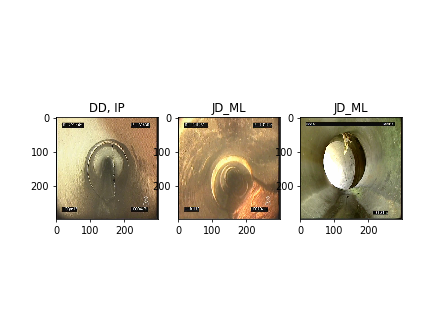

Left to right: ground truth samples from train, val test


In [7]:
def preprocess(image, caption):
    image = resize(image, image_dims, preserve_range=True)
    return preprocess_input(image.astype(np.float32)), caption
def postprocess(image):
    return ((image + 1) * 127).astype(np.uint8)

def pipeline(gen):
    return (
        onehot_gen(
            lambda_gen(
                gen
#                 caption_map_gen(gen, caption_map)
            , func=preprocess)
        , num_classes=num_classes))
    
train_gen = pipeline(coco_train.generator(shuffle_ids=True))
val_gen = pipeline(coco_val.generator(shuffle_ids=True))
test_gen = pipeline(coco_test.generator(shuffle_ids=True))
    
for i, (train, val, test) in enumerate(zip(train_gen, val_gen, test_gen)):
    print(train[0].shape, train[1])
    print(val[0].shape, val[1])
    print(test[0].shape, test[1])
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(postprocess(train[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(train[1])]))
    
    plt.subplot(1, 3, 2)
    plt.imshow(postprocess(val[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(val[1])]))
    
    plt.subplot(1, 3, 3)
    plt.imshow(postprocess(test[0]))
    plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(test[1])]))
    
    if i >= 0:
        break
print("Left to right: ground truth samples from train, val test")        

In [8]:
def gen_dump_data(gen, num_images):
    data = [[],[]]
    for i, (image, caption) in enumerate(gen):
        data[0].append(image)
        data[1].append(caption)
        if i >= num_images:
            break
    data = (
        np.concatenate([i[np.newaxis, ...] for i in data[0]], axis=0),
        np.concatenate([i[np.newaxis, ...] for i in data[1]], axis=0)
    )
    return data

val_data = gen_dump_data(val_gen, coco_val.num_images())
test_data = gen_dump_data(test_gen, coco_test.num_images())

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


# Setup model

In [9]:
def create_new_head(base_model, num_classes, train_features=False, activation='softmax', opt_params={}):
    '''make sure base_model has include_top=False'''
    from keras.layers import Dense, MaxPooling2D, Dropout, Flatten
    from keras.models import Model
    # add a global spatial average pooling layer
    x = base_model.output
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation=activation, name='class_logits')(x)


    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = train_features
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(**opt_params, metrics=['accuracy'])
    return model

In [10]:
K.clear_session()
model = create_new_head(
    InceptionV3(
        include_top=False, weights='imagenet', input_shape=image_dims),
    num_classes, train_features=False, activation='sigmoid',
    opt_params={'optimizer': "Nadam", 'loss': "categorical_crossentropy"})

87916544/87910968 [==============================] - 27s 0us/step


# Train model

In [11]:
best_path = os.path.join(log_dir, "models/best.{epoch:03d}-{val_loss:.4f}.h5")

callbacks=[
#         ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=10, cooldown=10, verbose=1),
        ModelCheckpoint(
            best_path, monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=True, mode='auto', period=1),
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            batch_size=batch_size,
            write_graph=True, write_grads=False, write_images=False),
#         EarlyStopping(
#             monitor='val_loss', min_delta=0.0, patience=40, verbose=1, mode='auto')
]


In [ ]:
# Train with initial LR
learning_rate = 1e-5
K.set_value(model.optimizer.lr, learning_rate)
model.fit_generator(
    batching_gen(train_gen, batch_size=batch_size),
    validation_data=tuple(val_data),
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    callbacks=callbacks, 
    epochs=10,
    verbose=1)

Epoch 1/10


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


594/594 [==============================] - 100s 169ms/step - loss: 1.9224 - acc: 0.2003 - val_loss: 2.7050 - val_acc: 0.2500

Epoch 00001: val_loss improved from 2.71071 to 2.70499, saving model to /mnt/ssd1/processed/industry-data/project-max/ml/front-facing/img-class-keras/models/best.001-2.7050.h5
Epoch 2/10
594/594 [==============================] - 100s 168ms/step - loss: 1.9173 - acc: 0.2340 - val_loss: 2.7138 - val_acc: 0.2500

Epoch 00002: val_loss did not improve from 2.70499
Epoch 3/10
432/594 [====================>.........] - ETA: 23s - loss: 1.8853 - acc: 0.2060

In [ ]:
# Train with smaller LR
learning_rate = 2e-6
K.set_value(model.optimizer.lr, learning_rate)
model.fit_generator(
    batching_gen(train_gen, batch_size=batch_size),
    validation_data=tuple(val_data),
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    callbacks=callbacks, 
    epochs=10,
    verbose=1)

In [ ]:
# Explicitly save model weights (note it is auto saved in the callback)
# model.save_weights("/tmp/where_you_want_it.h5")

# Multi-label Testing

Test accuracy: 0.55


<IPython.core.display.Javascript object>


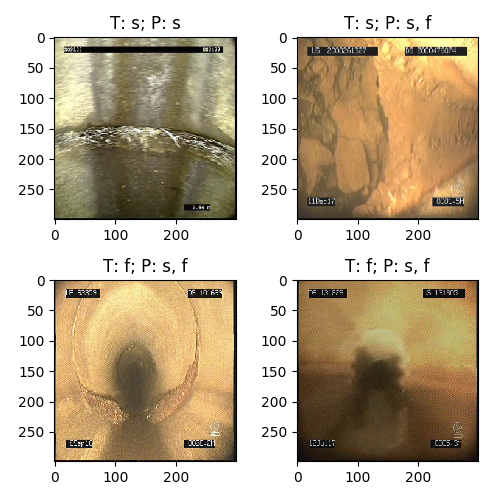

[0.5280612  0.07043453]
[0.914469  0.2598063]
[0.1125859  0.61270374]
[0.44183138 0.4568882 ]


<IPython.core.display.Javascript object>


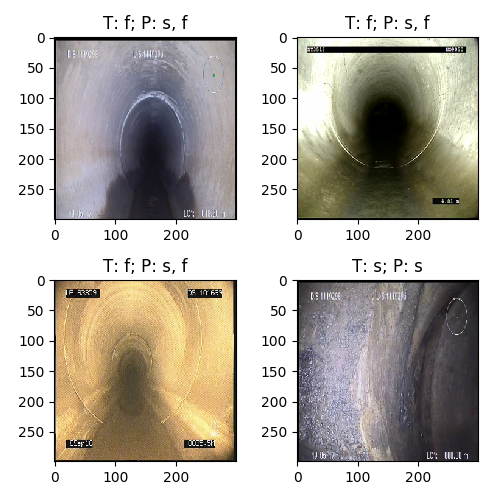

[0.12470153 0.4012548 ]
[0.60446393 0.45237586]
[0.4473013  0.31186315]
[0.94453627 0.01578325]


<IPython.core.display.Javascript object>


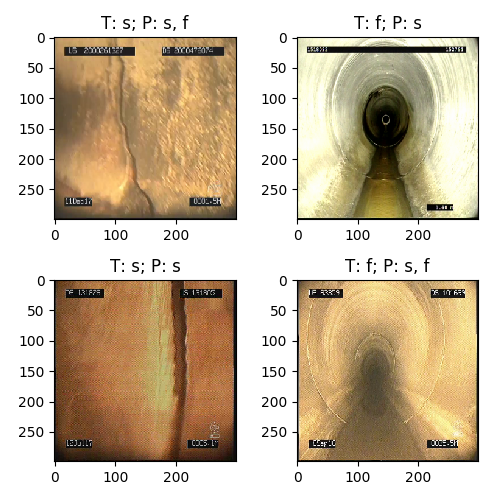

[0.32630208 0.47835565]
[0.4227251  0.09960505]
[0.9215243  0.04199442]
[0.4473013  0.31186315]


<IPython.core.display.Javascript object>


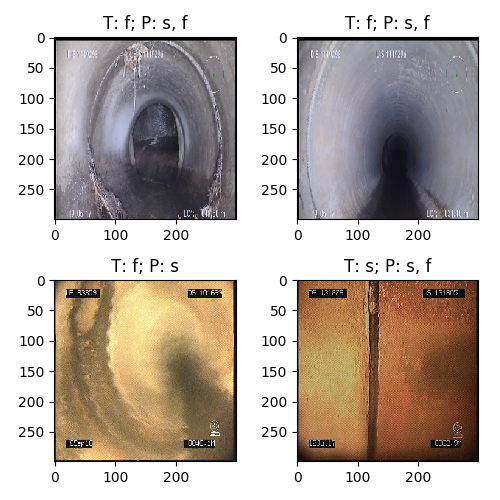

[0.56280065 0.22891074]
[0.65590984 0.25861946]
[0.6695613  0.09070139]
[0.57313424 0.10806597]


<IPython.core.display.Javascript object>


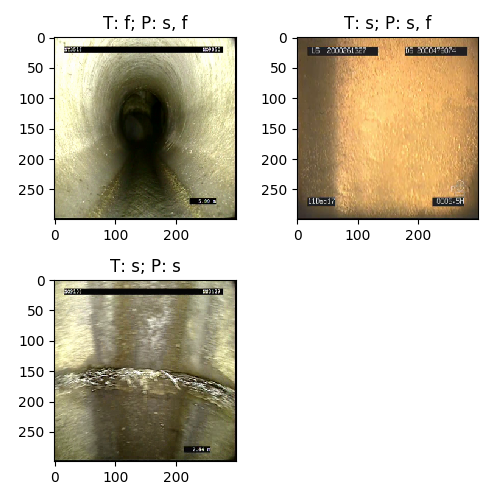

[0.41197056 0.4194433 ]
[0.7784949  0.15077539]
[0.5280612  0.07043453]


In [13]:
thresh = 0.1
Y_true = test_data[1]
Y_pred = model.predict(test_data[0])
TP = (Y_pred > thresh) == (Y_true > thresh)
print("Test accuracy: {:.2f}".format(np.count_nonzero(TP) / TP.size))

for i, (image, true_caption, pred_caption) in enumerate(zip(test_data[0], test_data[1], Y_pred)):
    if i % 4 == 0:
        plt.tight_layout()
        plt.figure(figsize=(5, 5))
#     if i >= 4:
#         break
    plt.subplot(2, 2, 1 + (i % 4))
    plt.imshow(postprocess(image))
    plt.title("T: {:s}; P: {:s}".format(
        ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(true_caption > thresh)]),
        ', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(pred_caption > thresh)])
    ))
    print(pred_caption)
plt.tight_layout()

In [ ]:
# def pipeline(gen, augment=False):
#     aug_config = {
#         'input_shape': image_size,
#         'output_shape': input_shape,
#         'spacing': 100,
#         'crop': False, # Only enable for object detection or segmentation datasets
#         'crops_per_image': 0, # Only enable for object detection or segmentation datasets
#         'flip_lr_percentage': 0.5,
#         'flip_ud_percentage': 0.5,
#         'affine': {
#             "order": 1,
#             'scale': {
#                 "x": (0.8, 1.2),
#                 "y": (0.8, 1.2)
#             },
#             "rotate": (-10, 10),
#             "shear": (-5, 5),
#             "mode": 'constant'
#         }
#     }
#     return (
#             lambda_gen(
#                 augmentation_gen(
#                     gen, aug_config=aug_config, enable=augment)
#             , func=preprocess)
#     )